In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import numpy as np
import sys
from PIL import Image
from scipy.stats import spearmanr as spr
from tqdm import tqdm_notebook as tqdm_loop

In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient
from captum.attr import visualization as viz

In [4]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image

In [5]:
sys.path.append("../../pytorch-cifar/models/")
from resnet_softplus import ResNet18 as resnet18_softplus
import resnet_softplus
from resnet import ResNet18 as resnet18_relu

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [7]:
data_mean = np.array([0.4914, 0.4822, 0.4465])
data_std = np.array([0.2023, 0.1994, 0.2010])

In [13]:
# models
model_standard = resnet18_softplus()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = resnet18_softplus()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)

In [14]:
# data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, 
                                          transform=transform_test)

test_loader = torch.utils.data.DataLoader(
        cifar_test,
        batch_size=32,
        shuffle=False
    )

Files already downloaded and verified


In [15]:
dataiter = iter(test_loader)
image, label = next(dataiter)
idx=10
img = image[idx].unsqueeze(dim=0).cuda()
img_label = label[idx]

Text(0.5, 1.0, 'CURE')

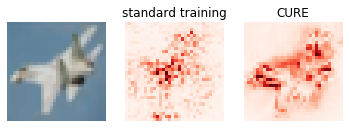

In [16]:
expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label)
expl_cure = get_expl(model_cure, img, "saliency")

fig, ax = plt.subplots(1,3, figsize=(6,2))
ax[0].imshow(torch_to_image(img, data_mean, data_std))
viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2]), use_pyplot=False)

for i in range(3):
    ax[i].axis('off')
ax[1].set_title("standard training")
ax[2].set_title("CURE")

### Cascade randomization of layers

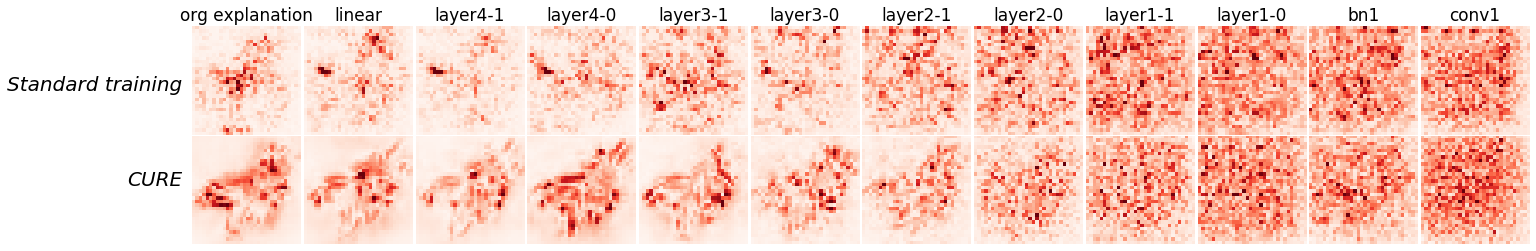

In [17]:
# cascade

layer_names = ["conv1", "bn1", 
              "layer1-0", "layer1-1",
              "layer2-0", "layer2-1",
              "layer3-0", "layer3-1",
              "layer4-0", "layer4-1",
              "linear", "org explanation"]
layer_names = layer_names[::-1]


expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label)
expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label)


fig, ax = plt.subplots(2, 12, figsize=(24, 4))
viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)



org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for child_name, child in model_standard.named_children():
    if isinstance(child, nn.Conv2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet_softplus.BasicBlock):
                org_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        org_layers_to_reinit.append(child)
    else:
        pass

org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet_softplus.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label)

    viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, i+1]), use_pyplot=False)
############CURE####################
cure_layers_to_reinit = []

for child_name, child in model_cure.named_children():
    if isinstance(child, nn.Conv2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet_softplus.BasicBlock):
                cure_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        cure_layers_to_reinit.append(child)
    else:
        pass

cure_layers_to_reinit = cure_layers_to_reinit[::-1]

for i, l in enumerate(cure_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet_softplus.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label)

    viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i+1]), use_pyplot=False)


    
    
for i in range(12):
    ax[0, i].set_title(layer_names[i], fontsize=17)
for i in range(2): 
    for j in range(12):
        ax[i,j].axis('off')
fig.text(0.12, 0.66, 'Standard training', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.33, 'CURE', style = 'oblique', fontsize = 20, horizontalalignment ='right')
# fig.text(0.12, 0.4, 'Uniform Grad', style = 'oblique', fontsize = 20, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("expls_cascade_randomized_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing with spr values

In [18]:
# models
model_standard = resnet18_softplus()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = resnet18_softplus()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)


expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label).detach().cpu()
expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label).detach().cpu()
torch.cuda.empty_cache()


org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for child_name, child in model_standard.named_children():
    if isinstance(child, nn.Conv2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet_softplus.BasicBlock):
                org_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        org_layers_to_reinit.append(child)
    else:
        pass

org_layers_to_reinit = org_layers_to_reinit[::-1]

# SPR VALUES
spr_standard = [1.0]
spr_cure = [1.0]

for i, l in enumerate(org_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet_softplus.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_standard_rand = get_expl(model_standard, img, "saliency", desired_index=img_label).detach().cpu()
    spr_standard.append(spr(expl_standard.flatten(), expl_standard_rand.flatten())[0])
    del expl_standard_rand
    torch.cuda.empty_cache()
    

############CURE###########################

cure_layers_to_reinit = []

for child_name, child in model_cure.named_children():
    if isinstance(child, nn.Conv2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet_softplus.BasicBlock):
                cure_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        cure_layers_to_reinit.append(child)
    else:
        pass

cure_layers_to_reinit = cure_layers_to_reinit[::-1]

for i, l in enumerate(cure_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet_softplus.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_cure_rand = get_expl(model_cure, img, "saliency", desired_index=img_label).detach().cpu()
    spr_cure.append(spr(expl_cure.flatten(), expl_cure_rand.flatten())[0])
    del expl_cure_rand
    torch.cuda.empty_cache()


yes
yes
yes
yes
yes
yes
yes
yes


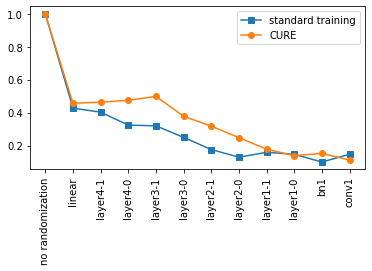

In [19]:
plt.figure(figsize=(6, 3))
plt.plot(spr_standard, label="standard training", marker="s")
plt.plot(spr_cure, label="CURE", marker="o")
plt.legend()
plt.xticks(range(12), ["no randomization"] + layer_names[1:], rotation=90);
plt.savefig("spr_cascade_randomized_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### checker board examples

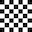

In [30]:
chess = Image.open("checkerboard32.png")
chess

In [35]:
x_chess = torchvision.transforms.ToTensor()(chess).unsqueeze(0).to(device)

In [38]:
x_chess = x_chess[:,0:3]

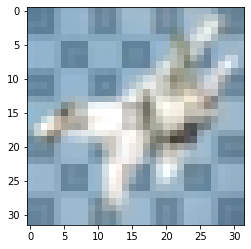

In [39]:
plt.imshow(torch_to_image(img+1*x_chess, data_mean, data_std))

In [40]:
# models
model_standard = resnet18_softplus()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = resnet18_softplus()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)

In [41]:
model_standard(img).argmax()

tensor(0, device='cuda:0')

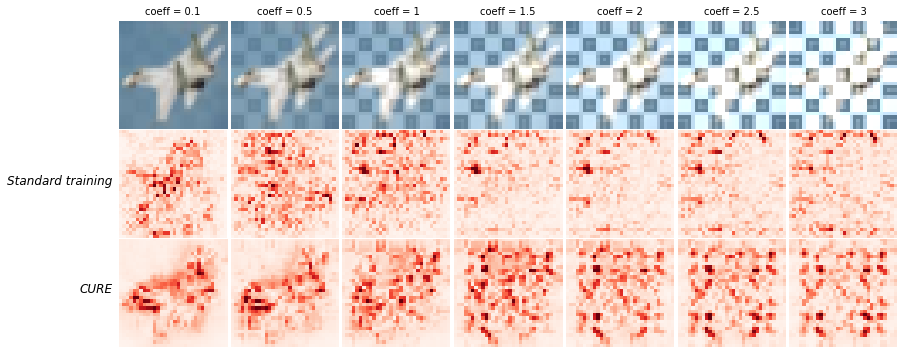

In [44]:
fig, ax = plt.subplots(3, 7, figsize=(14,6))
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].imshow(torch_to_image(img+c*x_chess, data_mean, data_std))
    expl_standard = get_expl(model_standard, img+c*x_chess, "saliency", desired_index=img_label)
    expl_cure = get_expl(model_cure, img+c*x_chess, "saliency", desired_index=img_label)
    viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i]), use_pyplot=False)
    
    
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].set_title("coeff = {}".format(c), fontsize=10)
for i in range(3):
    for j in range(7):
        ax[i,j].axis('off')
fig.text(0.12, 0.5, 'Standard training', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.25, 'CURE', style = 'oblique', fontsize = 12, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("checkerboard_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### adding a small object to an image

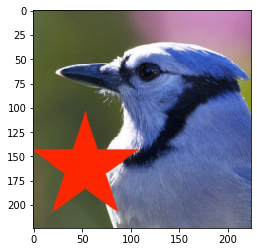

In [27]:
x_star = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0_star.jpg")
plt.imshow(torch_to_image(x_star, data_mean, data_std))

In [28]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [29]:
model(x_star).argmax()

tensor(17, device='cuda:0')

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


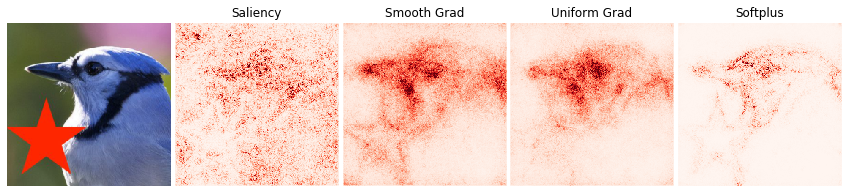

In [30]:
fig, ax = plt.subplots(1, 5, figsize=(15,3))
ax[0].imshow(torch_to_image(x_star, data_mean, data_std))

x_expl_grad = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
del x_expl_grad
torch.cuda.empty_cache()

x_expl_sg = get_expl(model, x_star, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[2]), use_pyplot=False)
del x_expl_sg
torch.cuda.empty_cache()

x_expl_ug = get_expl(model, x_star, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[3]), use_pyplot=False)
del x_expl_ug
torch.cuda.empty_cache()

##########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
x_expl_softplus = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[4]), use_pyplot=False)
del x_expl_softplus
torch.cuda.empty_cache()

ax[1].set_title("Saliency")
ax[2].set_title("Smooth Grad")
ax[3].set_title("Uniform Grad")
ax[4].set_title("Softplus")
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(5):
    ax[i].axis('off')
plt.savefig("added_object_expl.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)